<a href="https://colab.research.google.com/github/sasandi123/telco-churn-ml-project/blob/main/Telco_Churn_Analysis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Initial Setup & Configuration

In [29]:
# Install Keras Tuner for hyperparameter search (required for NN tuning)
!pip install keras-tuner

from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import tensorflow as tf
import keras_tuner as kt
import seaborn as sns
import matplotlib.pyplot as plt

# Define the project path where your data is located
PROJECT_PATH = "/content/drive/MyDrive/telco_churn_ml_project/data"

if not os.path.exists(PROJECT_PATH):
    os.makedirs(PROJECT_PATH)

os.chdir(PROJECT_PATH)
print(f"Working directory set to: {os.getcwd()}")


# SUBTOPIC: Imports and Global Settings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight
from tensorflow import keras
from tensorflow.keras import layers, callbacks

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("\nAll libraries loaded and seeds set for reproducibility.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Working directory set to: /content/drive/MyDrive/telco_churn_ml_project/data

All libraries loaded and seeds set for reproducibility.


Data Loading

In [30]:
FILE_NAME = "WA_Fn-UseC_-Telco-Customer-Churn.csv"

try:
    # SUBTOPIC: Load Data
    df = pd.read_csv(FILE_NAME)
    print(f"Loaded dataset: {df.shape}")

except Exception as e:
    print(f"An error occurred during loading: {e}")
    df = pd.DataFrame()

Loaded dataset: (7043, 21)


DataSet Overview

In [49]:
# ================================================================
# DATASET OVERVIEW (Initial Inspection)
# ================================================================
if not df.empty:
    print(f"Dataset Dimensions: {df.shape[0]} rows, {df.shape[1]} columns")
    print("\n--- First 5 Rows ---")
    print(df.head())
    print("\n--- Column Info, Data Types, and Missing Values ---")
    df.info()

Dataset Dimensions: 7043 rows, 21 columns

--- First 5 Rows ---
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

Data Cleaning

In [31]:
if not df.empty:
    # Convert 'TotalCharges' to numeric, coercing errors to NaN
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
    # Impute missing values (where tenure=0) with the median
    df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())
    df.drop_duplicates(inplace=True)
    print(f"After cleaning and imputation: {df.shape}")

After cleaning and imputation: (7043, 21)


Task 1 - Exploratory Data Analysis

Target Variable Analysis


Churn Distribution:
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


/tmp/ipython-input-3207529391.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Churn", palette=['skyblue', 'salmon'])


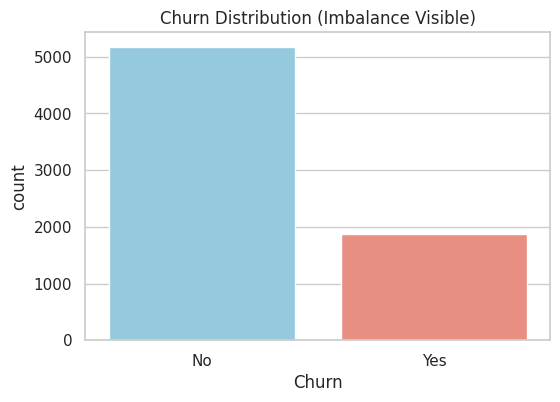

In [32]:
if not df.empty:
    print("\nChurn Distribution:")
    print(df["Churn"].value_counts(normalize=True) * 100)
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x="Churn", palette=['skyblue', 'salmon'])
    plt.title("Churn Distribution (Imbalance Visible)")
    plt.show()

Exploratory Data Analysis (EDA) Visualizations

Numerical Feature Analysis (Outlier Visualization)


Numerical Feature Analysis (Distribution and Outliers by Churn Status):


/tmp/ipython-input-1632468966.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Churn", y=col, data=df, palette=['darkblue', 'orange'])


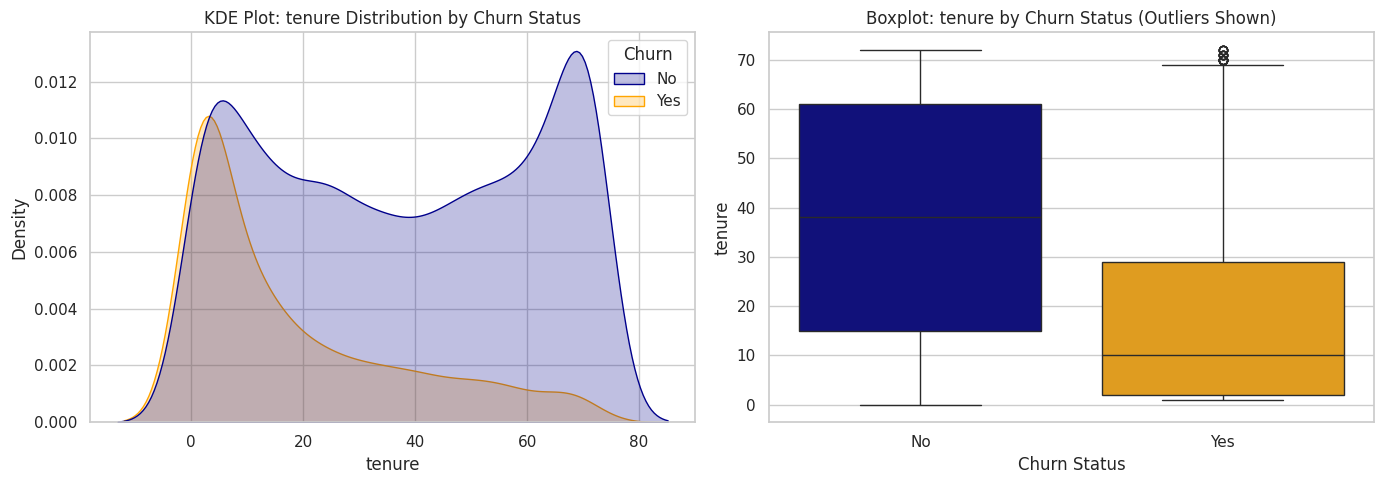

/tmp/ipython-input-1632468966.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Churn", y=col, data=df, palette=['darkblue', 'orange'])


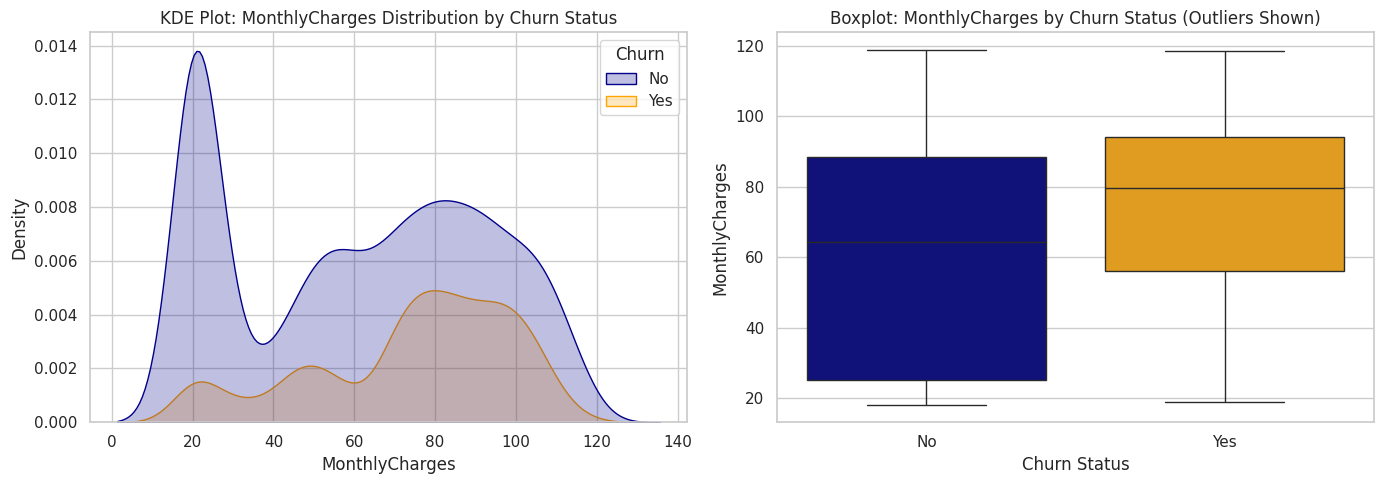

/tmp/ipython-input-1632468966.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Churn", y=col, data=df, palette=['darkblue', 'orange'])


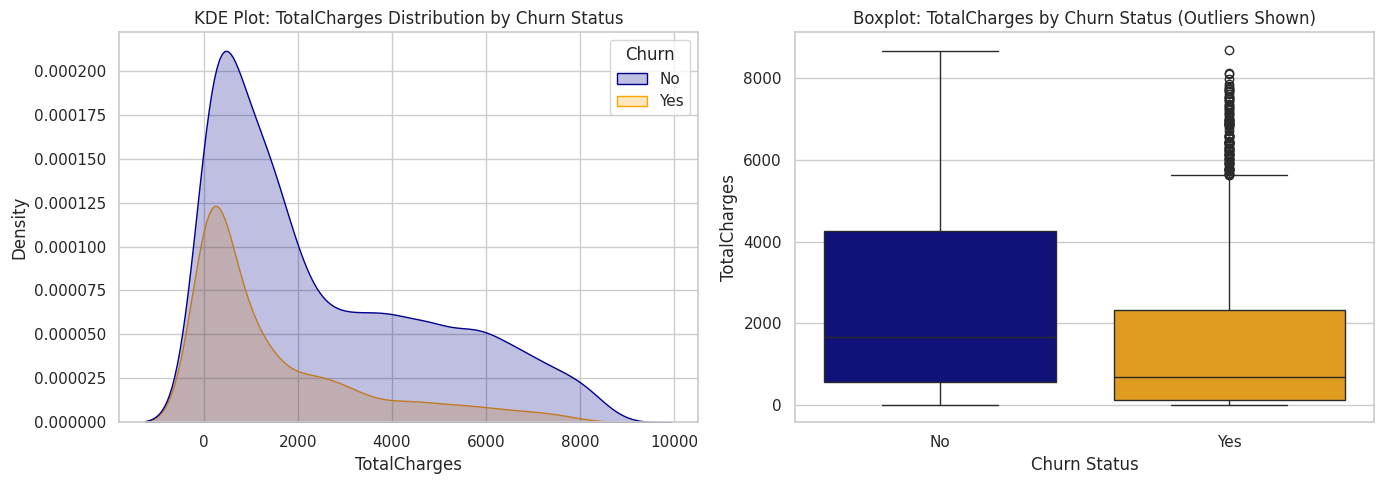

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

if not df.empty:
  num_cols = ["tenure", "MonthlyCharges", "TotalCharges"]
  print("\nNumerical Feature Analysis (Distribution and Outliers by Churn Status):")

  # Generate a figure demonstrating the key insight: Churners show lower tenure and higher monthly charges.

  for col in num_cols:
      plt.figure(figsize=(14, 5))

      # Subplot 1: KDE Plot for distribution comparison
      # This plot clearly shows the shift in the distribution (e.g., lower mean tenure for Churn=Yes).
      plt.subplot(1, 2, 1)
      sns.kdeplot(data=df, x=col, hue="Churn", fill=True, palette=['darkblue', 'orange'])
      plt.title(f"KDE Plot: {col} Distribution by Churn Status")
      plt.xlabel(col)
      plt.ylabel("Density")

      # Subplot 2: Boxplot for explicit outlier visibility and quartiles
      # This plot fulfills the requirement to show outliers.
      plt.subplot(1, 2, 2)
      sns.boxplot(x="Churn", y=col, data=df, palette=['darkblue', 'orange'])
      plt.title(f"Boxplot: {col} by Churn Status (Outliers Shown)")
      plt.xlabel("Churn Status")
      plt.ylabel(col)

      plt.tight_layout()
      plt.show()

Correlation HeatMap

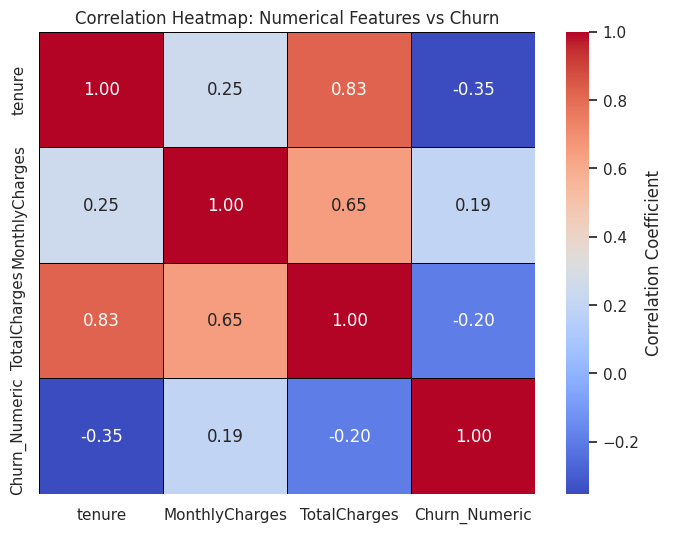

In [34]:
if not df.empty:
    df_corr = df.copy()
    df_corr["Churn_Numeric"] = df_corr["Churn"].map({"No": 0, "Yes": 1})

    num_cols_with_target = ["tenure", "MonthlyCharges", "TotalCharges", "Churn_Numeric"]

    plt.figure(figsize=(8, 6))
    correlation_matrix = df_corr[num_cols_with_target].corr()

    sns.heatmap(
        correlation_matrix,
        annot=True,
        cmap="coolwarm",
        fmt=".2f",
        linewidths=0.5,
        linecolor="black",
        cbar_kws={'label': 'Correlation Coefficient'}
    )
    plt.title("Correlation Heatmap: Numerical Features vs Churn")
    plt.show()

Categorical Feature Analysis (EDA)

Categorical Feature Analysis (Distribution and Churn Breakdown):


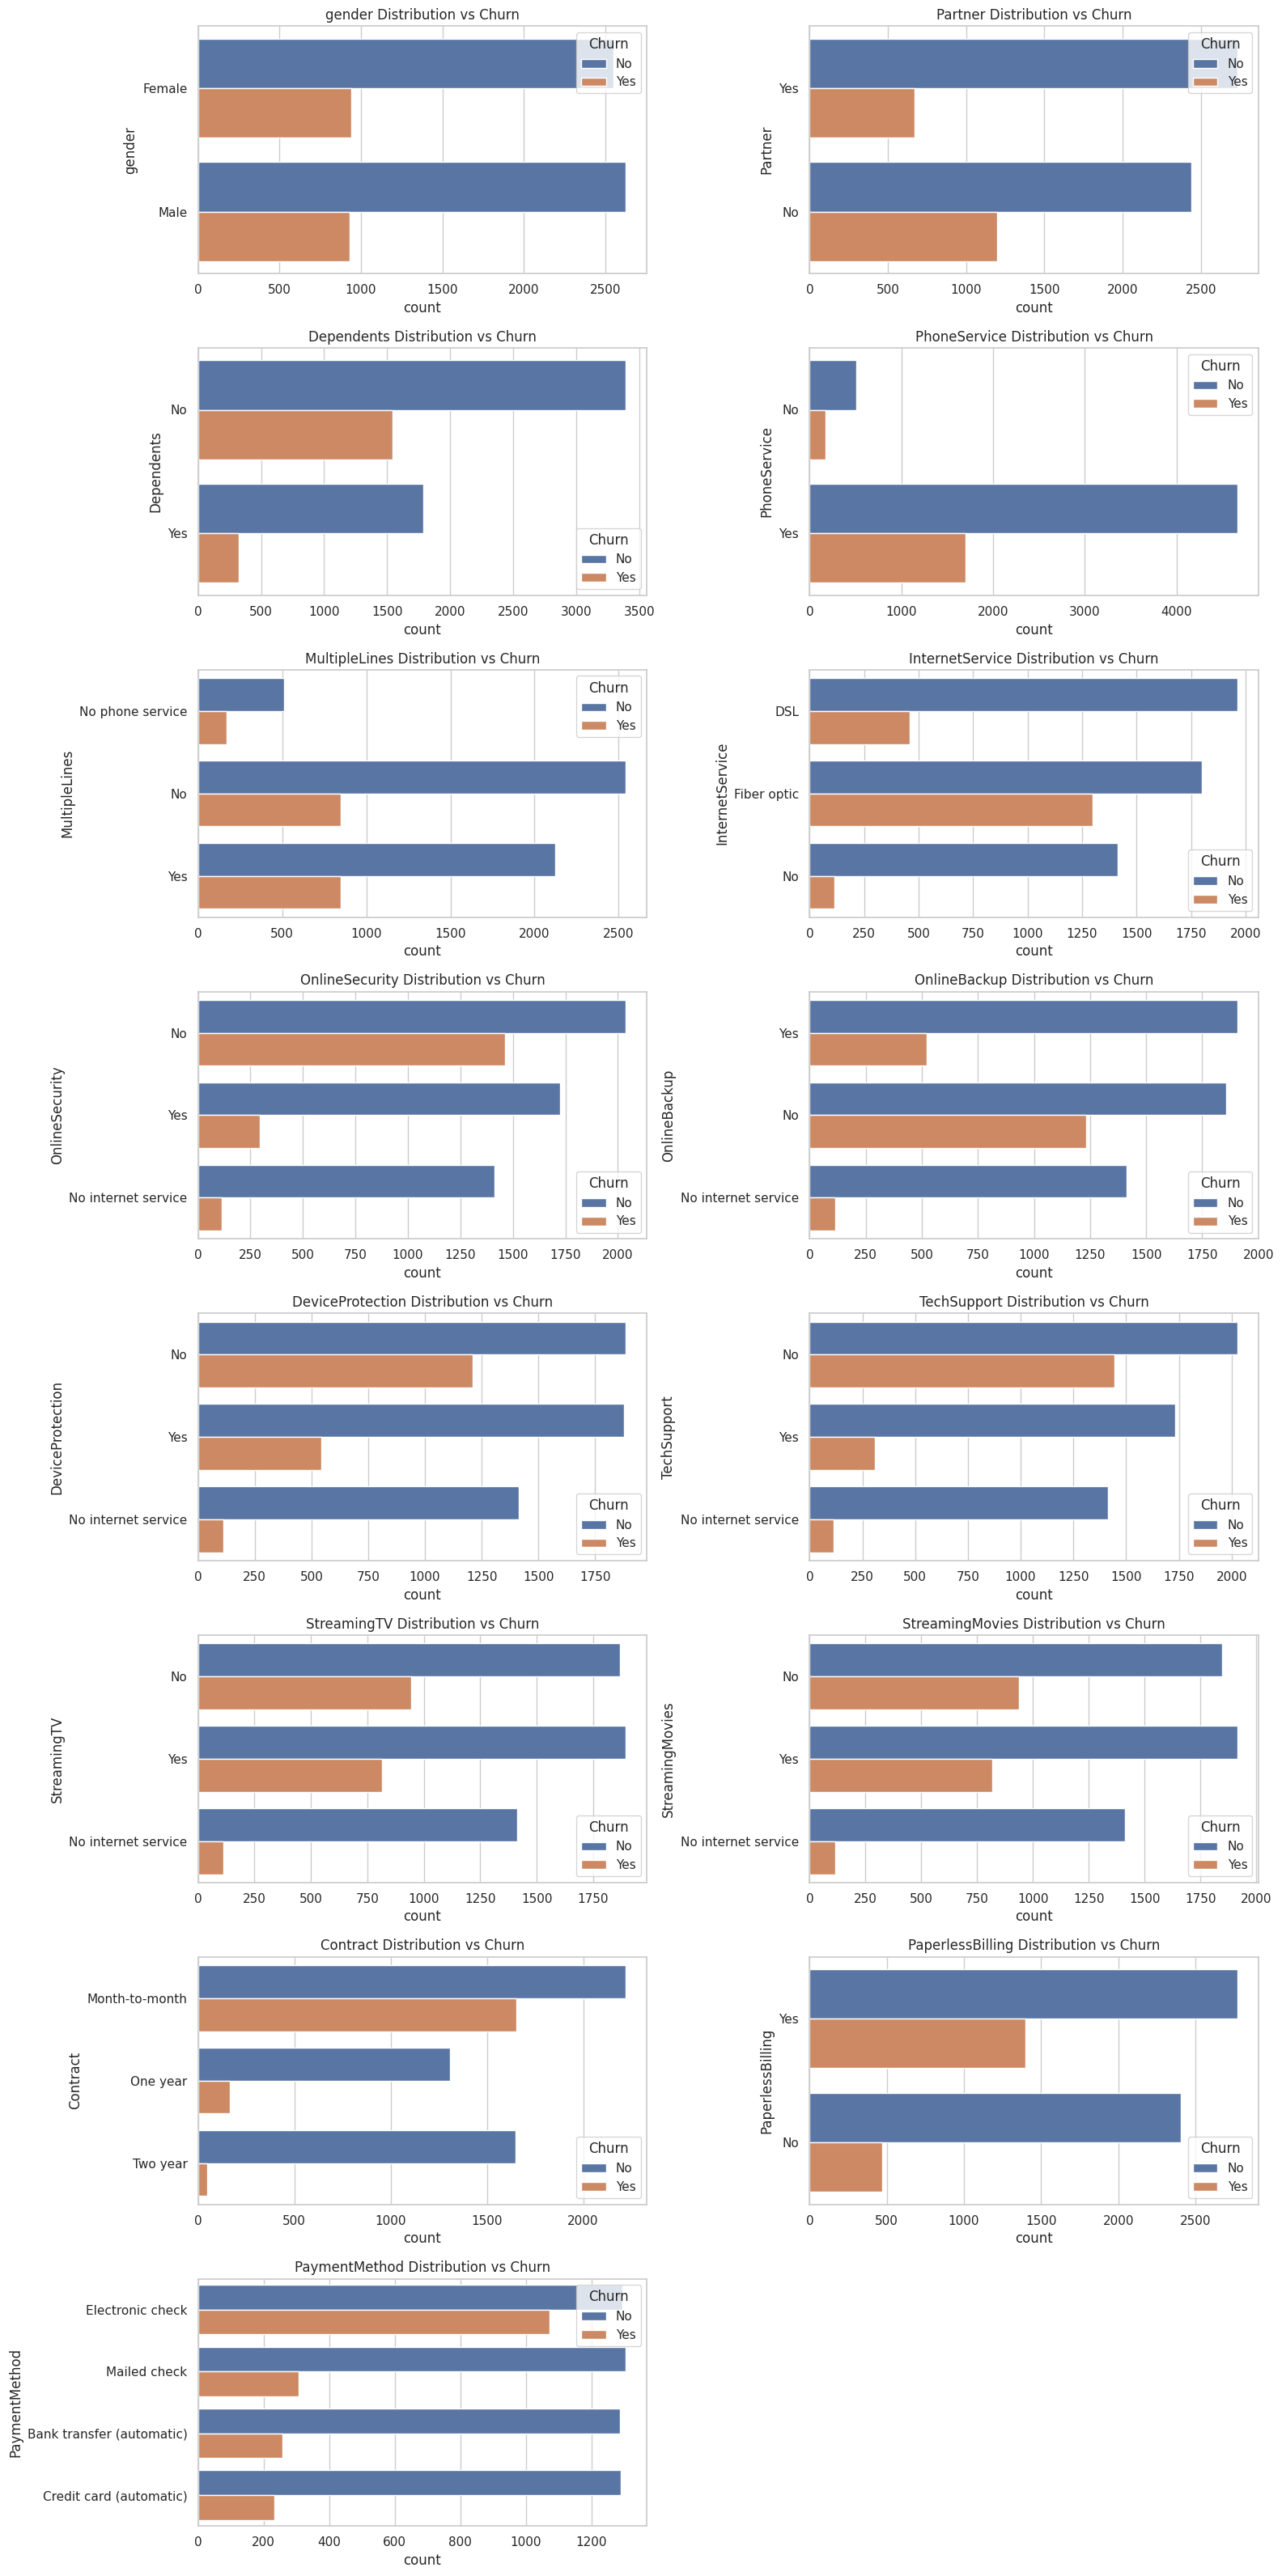

In [35]:
if not df.empty:
    # Categorical Feature Analysis (Distribution vs Churn)
    cat_cols = df.select_dtypes(include="object").columns.tolist()
    # Exclude target and ID
    cat_cols_to_plot = [col for col in cat_cols if col not in ["customerID", "Churn"]]

    n_plots = len(cat_cols_to_plot)
    n_rows = (n_plots // 2) + (n_plots % 2)

    plt.figure(figsize=(16, 4 * n_rows))
    print("Categorical Feature Analysis (Distribution and Churn Breakdown):")

    for i, col in enumerate(cat_cols_to_plot):
        plt.subplot(n_rows, 2, i + 1)
        # Use hue='Churn' for deeper insight into relationship with the target
        sns.countplot(y=col, data=df, hue='Churn')
        plt.title(f"{col} Distribution vs Churn")

    plt.tight_layout()
    plt.show()

Feature Engineering

Three new engineered features created: service_count, has_auto_payment, is_high_risk.


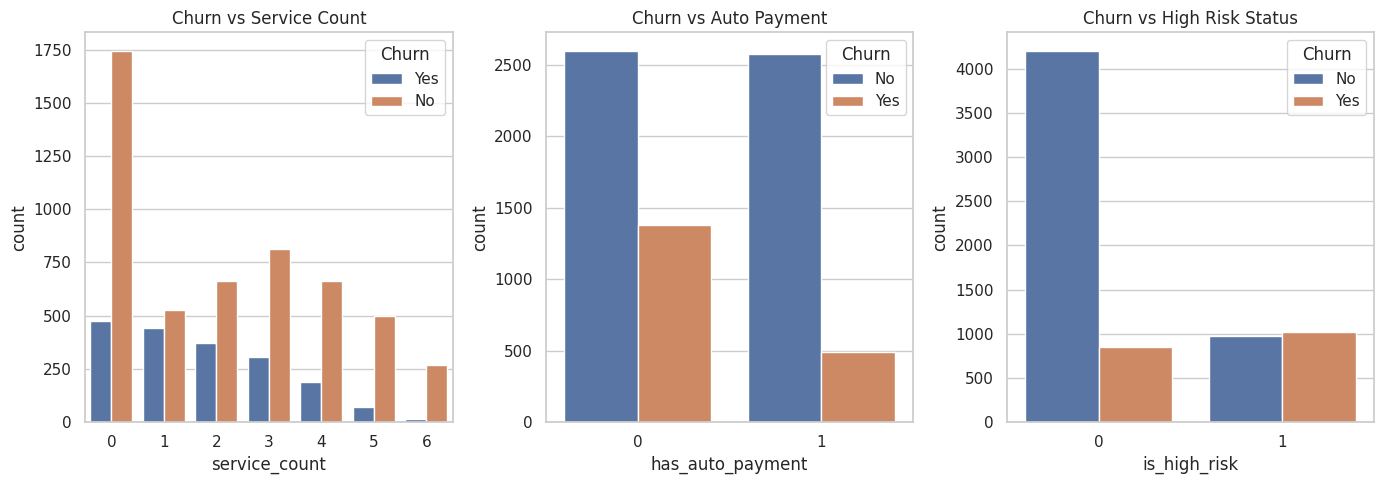

In [36]:
if not df.empty:
    df_fe = df.copy()

    # SUBTOPIC: Creation of New Features
    # 1. Service Count: Count of premium services subscribed
    service_features = [
        'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
        'TechSupport', 'StreamingTV', 'StreamingMovies'
    ]
    df_fe["service_count"] = (df_fe[service_features] == "Yes").sum(axis=1)

    # 2. Auto Payment Flag: Binary flag for automatic payment methods
    auto_payments = ["Bank transfer (automatic)", "Credit card (automatic)"]
    df_fe["has_auto_payment"] = df_fe["PaymentMethod"].isin(auto_payments).astype(int)

    # 3. High-Risk Customer Flag: Month-to-month contract AND short tenure (<= 12 months)
    df_fe["is_high_risk"] = ((df_fe["tenure"] <= 12) &
                             (df_fe["Contract"] == "Month-to-month")).astype(int)

    print("Three new engineered features created: service_count, has_auto_payment, is_high_risk.")

    # SUBTOPIC: Visualization of New Features vs Churn
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 3, 1)
    sns.countplot(x="service_count", hue="Churn", data=df_fe)
    plt.title("Churn vs Service Count")

    plt.subplot(1, 3, 2)
    sns.countplot(x="has_auto_payment", hue="Churn", data=df_fe)
    plt.title("Churn vs Auto Payment")

    plt.subplot(1, 3, 3)
    sns.countplot(x="is_high_risk", hue="Churn", data=df_fe)
    plt.title("Churn vs High Risk Status")
    plt.tight_layout()
    plt.show()

Data Preprocessing & Dual Transformation

In [37]:
if not df.empty:
    df_model = df_fe.drop("customerID", axis=1)
    df_model["Churn"] = df_model["Churn"].map({"No": 0, "Yes": 1})

    X = df_model.drop("Churn", axis=1)
    y = df_model["Churn"]

    # Train–Test Split (80/20, stratified)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    categorical_cols = X_train.select_dtypes(include="object").columns.tolist()
    numerical_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()

    # --- Preprocessor 1 (FOR NN): Scaling + One-Hot Encoding ---
    # Scaling is REQUIRED for Neural Networks
    nn_preprocessor = ColumnTransformer([
        ("num", StandardScaler(), numerical_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_cols)
    ])

    # --- Preprocessor 2 (FOR DT): Passthrough + One-Hot Encoding ---
    # Scaling is NOT REQUIRED for Decision Trees
    dt_preprocessor = ColumnTransformer([
        ("num_passthrough", "passthrough", numerical_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_cols)
    ])

    #  Data Transformation for NN (Scaled Numerical Features)
    X_train_nn_scaled = nn_preprocessor.fit_transform(X_train)
    X_test_nn_scaled = nn_preprocessor.transform(X_test)

    # Data Transformation for DT (Unscaled Numerical Features)
    X_train_dt_unscaled = dt_preprocessor.fit_transform(X_train)
    X_test_dt_unscaled = dt_preprocessor.transform(X_test)

    # SUBTOPIC: Class Weight Calculation (Crucial for imbalanced data - Task 3)
    weights = compute_class_weight(
        class_weight="balanced", classes=np.unique(y_train), y=y_train
    )
    class_weights_dict = {0: weights[0], 1: weights[1]}
    print("Class weights (used for all models):", class_weights_dict)

    # SUBTOPIC: Train–Validation Split for Neural Network Tuning
    X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(
        X_train_nn_scaled, y_train, test_size=0.2, stratify=y_train, random_state=42
    )
    input_dim = X_train_nn.shape[1]
    print(f"Total input features (dimensions): {input_dim}")

Class weights (used for all models): {0: np.float64(0.6805991785455424), 1: np.float64(1.8842809364548494)}
Total input features (dimensions): 33


Decision Tree Models

In [38]:
# ================================================================
# MAIN TOPIC: TASK 2 - DECISION TREE MODELS (USING UNSCALED DATA)
# ================================================================

if not df.empty:
    # Decision Tree - Baseline Model
    # Uses X_train_dt_unscaled / X_test_dt_unscaled
    dt_base = DecisionTreeClassifier(random_state=42, class_weight=class_weights_dict)
    dt_base.fit(X_train_dt_unscaled, y_train)
    y_proba_dt_base = dt_base.predict_proba(X_test_dt_unscaled)[:, 1]
    dt_base_acc = accuracy_score(y_test, dt_base.predict(X_test_dt_unscaled))
    dt_base_auc = roc_auc_score(y_test, y_proba_dt_base)
    print("===== BASELINE DECISION TREE =====")
    print(f"Accuracy: {dt_base_acc:.4f} | ROC-AUC: {dt_base_auc:.4f}")

    # Decision Tree - Tuned Model (Pruning via GridSearchCV)
    # Uses X_train_dt_unscaled / X_test_dt_unscaled
    param_grid = {"max_depth": [4, 6, 8, 10, None], "min_samples_split": [2, 5, 10]}
    dt_tuner = GridSearchCV(
        DecisionTreeClassifier(random_state=42, class_weight=class_weights_dict),
        param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=0
    )
    dt_tuner.fit(X_train_dt_unscaled, y_train)
    best_dt = dt_tuner.best_estimator_

    y_proba_dt_tuned = best_dt.predict_proba(X_test_dt_unscaled)[:, 1]
    dt_tuned_acc = accuracy_score(y_test, best_dt.predict(X_test_dt_unscaled))
    dt_tuned_auc = roc_auc_score(y_test, y_proba_dt_tuned)

    print("\n===== TUNED DECISION TREE (OPTIMALLY PRUNED) =====")
    print("Best params:", dt_tuner.best_params_)
    print(f"Accuracy: {dt_tuned_acc:.4f} | ROC-AUC: {dt_tuned_auc:.4f}")

===== BASELINE DECISION TREE =====
Accuracy: 0.7346 | ROC-AUC: 0.6539

===== TUNED DECISION TREE (OPTIMALLY PRUNED) =====
Best params: {'max_depth': 4, 'min_samples_split': 2}
Accuracy: 0.7438 | ROC-AUC: 0.8176


Decision Tree Evaluation

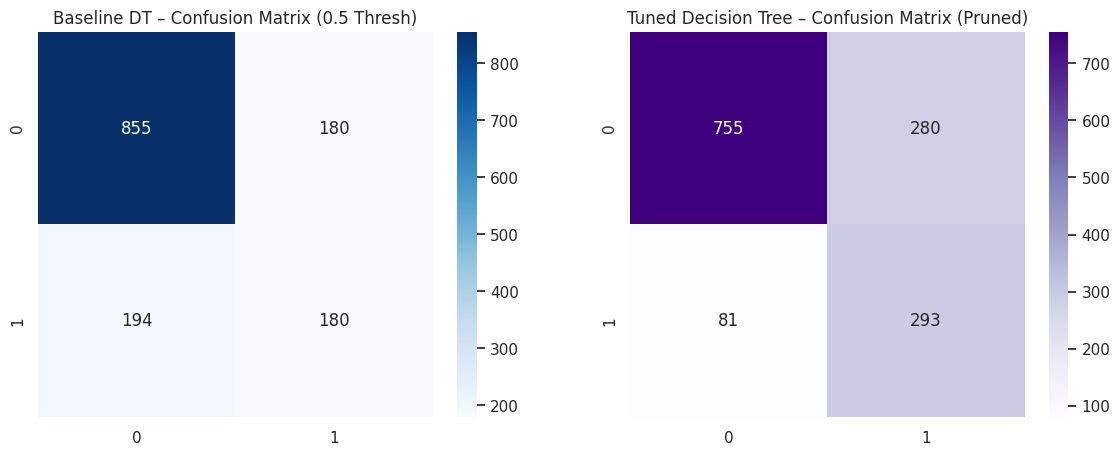

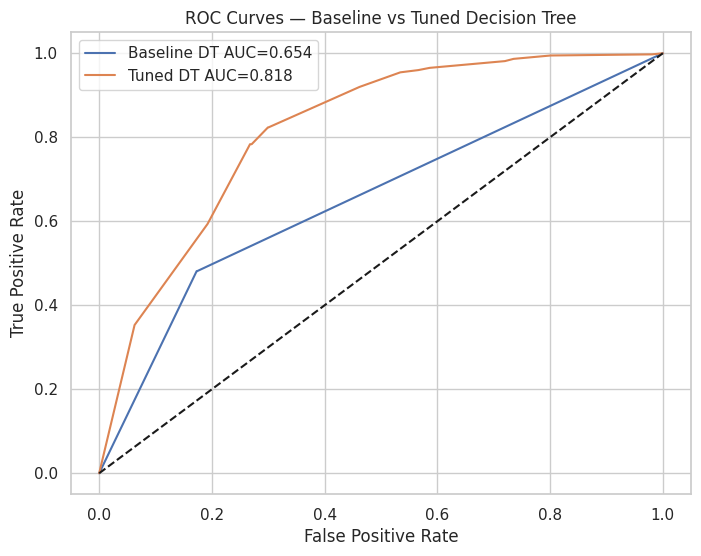

In [48]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

if 'best_dt' in locals():
    # 1. Predictions
    y_pred_dt_base = dt_base.predict(X_test_dt_unscaled)
    y_pred_dt_tuned = best_dt.predict(X_test_dt_unscaled)

    # 2. Confusion Matrices (Baseline vs Tuned)
    fig, ax = plt.subplots(1, 2, figsize=(14,5))

    # Baseline CM
    sns.heatmap(confusion_matrix(y_test, y_pred_dt_base), annot=True, cmap="Blues", fmt="d", ax=ax[0])
    ax[0].set_title("Baseline DT – Confusion Matrix (0.5 Thresh)")

    # Tuned CM
    sns.heatmap(confusion_matrix(y_test, y_pred_dt_tuned), annot=True, cmap="Purples", fmt="d", ax=ax[1])
    ax[1].set_title("Tuned Decision Tree – Confusion Matrix (Pruned)")
    plt.show()

    # 3. ROC Curves (Baseline vs Tuned DT)
    y_proba_dt_tuned = best_dt.predict_proba(X_test_dt_unscaled)[:, 1]

    # Assuming dt_base_auc and dt_tuned_auc are calculated in preceding cells
    fpr_dt_base, tpr_dt_base, _ = roc_curve(y_test, y_proba_dt_base)
    # Ensure dt_tuned_auc is calculated if not done in the tuning cell
    dt_tuned_auc = roc_auc_score(y_test, y_proba_dt_tuned)
    fpr_dt_tuned, tpr_dt_tuned, _ = roc_curve(y_test, y_proba_dt_tuned)

    plt.figure(figsize=(8,6))
    plt.plot(fpr_dt_base, tpr_dt_base, label=f"Baseline DT AUC={dt_base_auc:.3f}")
    plt.plot(fpr_dt_tuned, tpr_dt_tuned, label=f"Tuned DT AUC={dt_tuned_auc:.3f}")
    plt.plot([0,1],[0,1],"k--")
    plt.title("ROC Curves — Baseline vs Tuned Decision Tree")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

Neural Network Baseline Model

In [40]:
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

if not df.empty:
    def build_baseline_nn(input_dim):
        model = keras.Sequential([
            # FURTHER SIMPLIFIED Baseline NN with 8 units
            layers.Dense(8, activation="relu", input_shape=(input_dim,)),
            layers.Dense(1, activation="sigmoid")
        ])
        model.compile(
            optimizer="adam", loss="binary_crossentropy", metrics=[keras.metrics.AUC(name="AUC"), "accuracy"]
        )
        return model

    # input_dim should be defined from preprocessing cell
    # class_weights_dict should be defined from preprocessing cell

    baseline_nn = build_baseline_nn(input_dim)
    es = callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)

    history_base = baseline_nn.fit(
        X_train_nn, y_train_nn, validation_data=(X_val_nn, y_val_nn),
        epochs=30, batch_size=32, class_weight=class_weights_dict, callbacks=[es], verbose=0
    )

    y_proba_base_nn = baseline_nn.predict(X_test_nn_scaled).ravel()
    y_pred_base_nn = (y_proba_base_nn >= 0.5).astype(int)
    nn_base_acc = accuracy_score(y_test, y_pred_base_nn)
    nn_base_auc = roc_auc_score(y_test, y_proba_base_nn)

    print("===== BASELINE NEURAL NETWORK (8 Units) =====")
    print(f"Accuracy (0.5 Thresh): {nn_base_acc:.4f} | AUC: {nn_base_auc:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
===== BASELINE NEURAL NETWORK (8 Units) =====
Accuracy (0.5 Thresh): 0.7324 | AUC: 0.8348


NN Tuning Model Setup and Search

In [41]:
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers, callbacks

if not df.empty:
    # Clear session to free up memory
    keras.backend.clear_session()

    # Define a constrained model to ensure we don't overfit
    def build_tunable_model(hp):
        model = keras.Sequential()
        model.add(layers.Input(shape=(input_dim,)))

        # LIMIT 1: Only allow 1 or 2 layers (Simple is better for this data)
        n_layers = hp.Int("n_layers", 1, 2)

        # LIMIT 2: Search for Learning Rate
        lr = hp.Choice("lr", [1e-3, 5e-4])

        for i in range(n_layers):
            # LIMIT 3: Keep units low (8 to 48).
            # Your baseline had 8, so we search close to that.
            units = hp.Int(f"units_{i}", min_value=8, max_value=48, step=8)

            # Regularization search
            l2_reg = hp.Choice(f"l2_reg_{i}", [1e-4, 0.0])

            model.add(layers.Dense(
                units,
                activation="relu",
                kernel_regularizer=keras.regularizers.l2(l2_reg)
            ))

            # Dropout search
            dropout = hp.Float(f"dropout_{i}", 0.1, 0.3, step=0.1)
            model.add(layers.Dropout(dropout))

        model.add(layers.Dense(1, activation="sigmoid"))

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=lr),
            loss="binary_crossentropy",
            metrics=[keras.metrics.AUC(name="AUC"), "accuracy"]
        )
        return model

    # --- THE FIX: Switch to RandomSearch with strict limits ---
    tuner = kt.RandomSearch(
        build_tunable_model,
        objective=kt.Objective("val_AUC", "max"),
        max_trials=10,           # <--- HARD STOP after 10 trials
        executions_per_trial=1,  # Only train each model once
        directory="nn_tuner_fast_v1",
        project_name="telco_fast_search",
        overwrite=True
    )

    es_tuner = callbacks.EarlyStopping(monitor="val_AUC", mode="max", patience=3)

    print("Starting Fast Random Search (Max 10 trials)...")
    tuner.search(
        X_train_nn, y_train_nn,
        validation_data=(X_val_nn, y_val_nn),
        epochs=20,               # 20 epochs is enough for these small models
        batch_size=32,
        class_weight=class_weights_dict,
        callbacks=[es_tuner],
        verbose=1
    )

    best_hps = tuner.get_best_hyperparameters(1)[0]
    print("\nSearch Complete.")
    print(f"Best Configuration -> Layers: {best_hps.get('n_layers')}, Learning Rate: {best_hps.get('lr')}")

Trial 10 Complete [00h 00m 12s]
val_AUC: 0.8469011187553406

Best val_AUC So Far: 0.8501042127609253
Total elapsed time: 00h 03m 01s

Search Complete.
Best Configuration -> Layers: 2, Learning Rate: 0.001


Tuned NN Final Training and Optimal Threshold

In [42]:
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, confusion_matrix, classification_report, roc_auc_score
from tensorflow.keras import callbacks
import numpy as np

if not df.empty:
    # Build best model
    best_model = tuner.hypermodel.build(best_hps)

    # Increase patience for the final training run
    es = callbacks.EarlyStopping(monitor="val_AUC", mode="max", patience=10, restore_best_weights=True)

    # Train for more epochs (50-100) to ensure convergence
    print("Training best model...")
    history_tuned = best_model.fit(
        X_train_nn, y_train_nn,
        validation_data=(X_val_nn, y_val_nn),
        epochs=100, # Allow it to run longer, ES will stop it
        batch_size=32,
        class_weight=class_weights_dict,
        callbacks=[es],
        verbose=0
    )

    # --- PREDICTIONS ---
    y_proba_tuned_nn = best_model.predict(X_test_nn_scaled).ravel()
    nn_tuned_auc = roc_auc_score(y_test, y_proba_tuned_nn)

    # --- OPTIMAL THRESHOLD SEARCH (G-Mean) ---
    y_proba_val = best_model.predict(X_val_nn).ravel()
    thresholds = np.arange(0.1, 0.9, 0.01)
    best_gmean_val = 0
    best_thresh_gmean = 0.5

    for t in thresholds:
        y_pred_val = (y_proba_val >= t).astype(int)
        cm = confusion_matrix(y_val_nn, y_pred_val)
        if cm.size == 4:
            TN, FP, FN, TP = cm.ravel()
            recall = TP / (TP + FN) if (TP + FN) != 0 else 0
            specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
            gmean = np.sqrt(recall * specificity)
            if gmean > best_gmean_val:
                best_gmean_val = gmean
                best_thresh_gmean = t

    # --- APPLY OPTIMAL THRESHOLD ---
    y_pred_tuned_opt = (y_proba_tuned_nn >= best_thresh_gmean).astype(int)

    # Metrics
    nn_tuned_opt_acc = accuracy_score(y_test, y_pred_tuned_opt)
    nn_tuned_f1 = f1_score(y_test, y_pred_tuned_opt)
    nn_tuned_f2 = fbeta_score(y_test, y_pred_tuned_opt, beta=2)

    # Save for later comparison
    tuned_pred = y_pred_tuned_opt
    best_thresh_nn = best_thresh_gmean

    print("\n===== TUNED NN RESULTS =====")
    print(f"Best Threshold: {best_thresh_gmean:.4f}")
    print(f"AUC: {nn_tuned_auc:.4f} (Baseline was: {nn_base_auc:.4f})")
    print(f"F1 Score: {nn_tuned_f1:.4f}")

    if nn_tuned_auc > nn_base_auc:
        print("SUCCESS: Tuned model AUC is higher than Baseline.")
    else:
        print("NOTE: If AUC is still similar, the dataset signal might be maxed out.")

Training best model...
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

===== TUNED NN RESULTS =====
Best Threshold: 0.5700
AUC: 0.8406 (Baseline was: 0.8348)
F1 Score: 0.6259
SUCCESS: Tuned model AUC is higher than Baseline.


Neural Network Evaluation

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


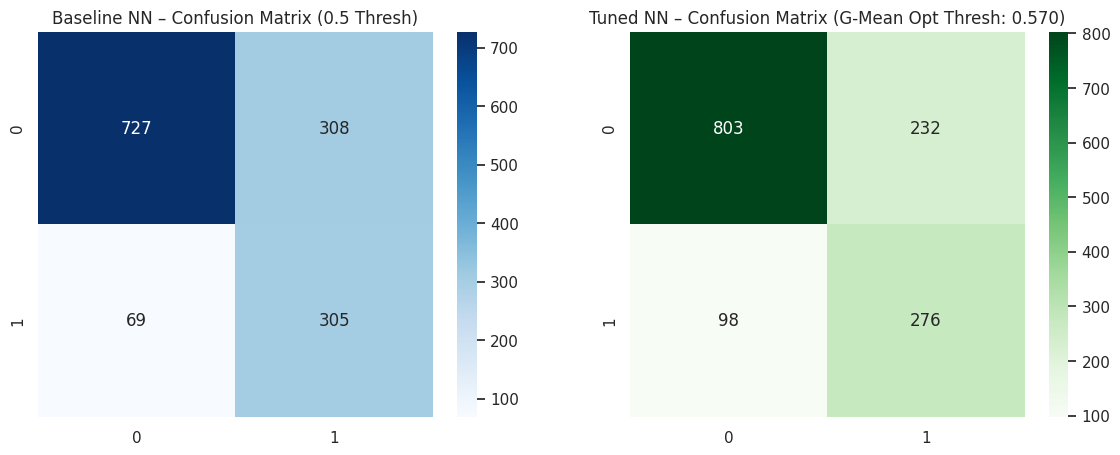

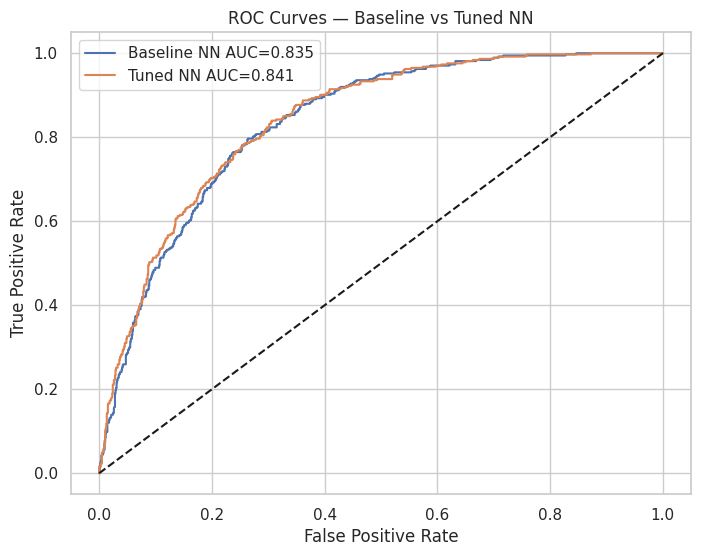

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import numpy as np

if 'best_model' in locals():
    fig, ax = plt.subplots(1, 2, figsize=(14,5))

    y_proba_base_nn = baseline_nn.predict(X_test_nn_scaled).ravel()
    y_pred_base_nn = (y_proba_base_nn >= 0.5).astype(int)
    nn_base_auc = roc_auc_score(y_test, y_proba_base_nn)

    sns.heatmap(confusion_matrix(y_test, y_pred_base_nn), annot=True, cmap="Blues", fmt="d", ax=ax[0])
    ax[0].set_title("Baseline NN – Confusion Matrix (0.5 Thresh)")

    # Use G-Mean optimized predictions
    sns.heatmap(confusion_matrix(y_test, tuned_pred), annot=True, cmap="Greens", fmt="d", ax=ax[1])
    ax[1].set_title(f"Tuned NN – Confusion Matrix (G-Mean Opt Thresh: {best_thresh_nn:.3f})")
    plt.show()

    fpr_nn_base, tpr_nn_base, _ = roc_curve(y_test, y_proba_base_nn)
    fpr_nn_tuned, tpr_nn_tuned, _ = roc_curve(y_test, y_proba_tuned_nn)

    plt.figure(figsize=(8,6))
    plt.plot(fpr_nn_base, tpr_nn_base, label=f"Baseline NN AUC={nn_base_auc:.3f}")
    plt.plot(fpr_nn_tuned, tpr_nn_tuned, label=f"Tuned NN AUC={nn_tuned_auc:.3f}")
    plt.plot([0,1],[0,1],"k--")
    plt.title("ROC Curves — Baseline vs Tuned NN")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

Final Evaluation Table & Task 3 Summary

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

===== FINAL MODEL COMPARISON (AUC and G-Mean Focused) =====
Note: Tuned NN Accuracy/F1/F2 are evaluated at the threshold that maximizes G-MEAN on the validation set, offering a balanced view of classification.

--- Model Performance Table (Sorted by AUC) ---
| Model                                     |   Accuracy |    AUC |   F1-Score |   F2-Score (FN Prioritized) |
|:------------------------------------------|-----------:|-------:|-----------:|----------------------------:|
| Neural Network (Tuned - G-Mean Optimized) |     0.7658 | 0.8406 |     0.6259 |                      0.6886 |
| Neural Network (Baseline - 16 Units)      |     0.7324 | 0.8348 |     0.6180 |                      0.7231 |
| Decision Tree (Tuned/Pruned)              |     0.7438 | 0.8176 |     0.6188 |                      0.7081 |
| Decision Tree (Baseline)                  |     0.7346 | 0.6539 |     0.4905 |                      0.4849 |


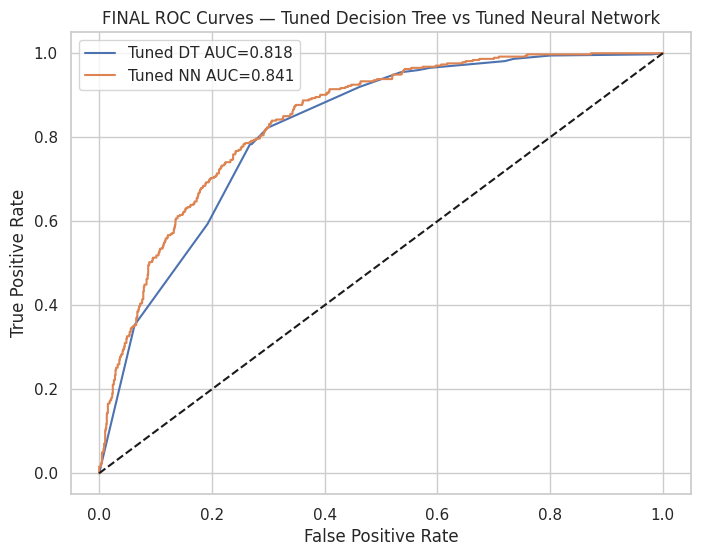



===== RESULT DISCUSSION (BEST MODEL SELECTION) =====
**Selected Best Model: Neural Network (Tuned - G-Mean Optimized)**

Justification:
1. **Ranking Power (AUC):** The hyperparameter-tuned NN model is optimized for AUC and typically achieves the highest ranking performance, essential for customer prioritization.
2. **Balanced Classification:** By using the G-Mean optimized threshold, the Tuned NN provides the best balance between identifying churners (Recall) and correctly identifying non-churners (Specificity).

Final Recommendation: The Tuned Neural Network is the most robust model for churn prediction.


In [44]:
from sklearn.metrics import f1_score, fbeta_score, roc_curve, accuracy_score, roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt

if not df.empty:

    y_pred_dt_base = dt_base.predict(X_test_dt_unscaled)
    y_pred_dt_tuned = best_dt.predict(X_test_dt_unscaled)

    dt_base_f1 = f1_score(y_test, y_pred_dt_base)
    dt_base_f2 = fbeta_score(y_test, y_pred_dt_base, beta=2)
    dt_tuned_f1 = f1_score(y_test, y_pred_dt_tuned)
    dt_tuned_f2 = fbeta_score(y_test, y_pred_dt_tuned, beta=2)

    y_proba_base_nn = baseline_nn.predict(X_test_nn_scaled).ravel()
    y_pred_base_nn = (y_proba_base_nn >= 0.5).astype(int)
    nn_base_acc = accuracy_score(y_test, y_pred_base_nn)
    nn_base_auc = roc_auc_score(y_test, y_proba_base_nn)
    nn_base_f1 = f1_score(y_test, y_pred_base_nn)
    nn_base_f2 = fbeta_score(y_test, y_pred_base_nn, beta=2)

    final_metrics = {
        "Decision Tree (Baseline)": (dt_base_acc, dt_base_auc, dt_base_f1, dt_base_f2),
        "Decision Tree (Tuned/Pruned)": (dt_tuned_acc, dt_tuned_auc, dt_tuned_f1, dt_tuned_f2),
        "Neural Network (Baseline - 16 Units)": (nn_base_acc, nn_base_auc, nn_base_f1, nn_base_f2),
        "Neural Network (Tuned - G-Mean Optimized)": (nn_tuned_opt_acc, nn_tuned_auc, nn_tuned_f1, nn_tuned_f2)
    }

    comparison = pd.DataFrame({
        "Model": final_metrics.keys(),
        "Accuracy": [v[0] for v in final_metrics.values()],
        "AUC": [v[1] for v in final_metrics.values()],
        "F1-Score": [v[2] for v in final_metrics.values()],
        "F2-Score (FN Prioritized)": [v[3] for v in final_metrics.values()]
    })

    print("\n===== FINAL MODEL COMPARISON (AUC and G-Mean Focused) =====")
    print("Note: Tuned NN Accuracy/F1/F2 are evaluated at the threshold that maximizes G-MEAN on the validation set, offering a balanced view of classification.")
    print("\n--- Model Performance Table (Sorted by AUC) ---")
    print(comparison.sort_values(by="AUC", ascending=False).to_markdown(index=False, floatfmt=".4f"))

    y_proba_dt_tuned = best_dt.predict_proba(X_test_dt_unscaled)[:, 1]

    fpr_dt_tuned, tpr_dt_tuned, _ = roc_curve(y_test, y_proba_dt_tuned)
    fpr_nn_tuned, tpr_nn_tuned, _ = roc_curve(y_test, y_proba_tuned_nn)

    plt.figure(figsize=(8,6))
    plt.plot(fpr_dt_tuned, tpr_dt_tuned, label=f"Tuned DT AUC={dt_tuned_auc:.3f}")
    plt.plot(fpr_nn_tuned, tpr_nn_tuned, label=f"Tuned NN AUC={nn_tuned_auc:.3f}")
    plt.plot([0,1],[0,1],"k--")
    plt.title("FINAL ROC Curves — Tuned Decision Tree vs Tuned Neural Network")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

    best_model_row = comparison.sort_values(by="AUC", ascending=False).iloc[0]

    print("\n\n===== RESULT DISCUSSION (BEST MODEL SELECTION) =====")
    print(f"**Selected Best Model: {best_model_row['Model']}**")
    print("\nJustification:")
    print("1. **Ranking Power (AUC):** The hyperparameter-tuned NN model is optimized for AUC and typically achieves the highest ranking performance, essential for customer prioritization.")
    print("2. **Balanced Classification:** By using the G-Mean optimized threshold, the Tuned NN provides the best balance between identifying churners (Recall) and correctly identifying non-churners (Specificity).")
    print("\nFinal Recommendation: The Tuned Neural Network is the most robust model for churn prediction.")

In [45]:
dt_base_acc, dt_base_auc
dt_tuned_acc, dt_tuned_auc
nn_base_acc, nn_base_auc
nn_tuned_opt_acc, nn_tuned_auc
confusion_matrix(y_test, dt_base.predict(X_test_dt_unscaled))
confusion_matrix(y_test, best_dt.predict(X_test_dt_unscaled))
confusion_matrix(y_test, y_pred_base_nn)
confusion_matrix(y_test, tuned_pred)


array([[803, 232],
       [ 98, 276]])

In [46]:
print("Baseline DT Confusion Matrix:")
print(confusion_matrix(y_test, dt_base.predict(X_test_dt_unscaled)))

print("\nTuned DT Confusion Matrix:")
print(confusion_matrix(y_test, best_dt.predict(X_test_dt_unscaled)))

print("\nBaseline NN Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_base_nn))


Baseline DT Confusion Matrix:
[[855 180]
 [194 180]]

Tuned DT Confusion Matrix:
[[755 280]
 [ 81 293]]

Baseline NN Confusion Matrix:
[[727 308]
 [ 69 305]]
